# Counterfactual Explanations - LTV

**Counterfactual Explanations (CE)** fall under the category of explainable/interpretable AI and Machine Learning Interpretability (MLI) methods. Given a predictive supervised ML model, CE methods explore how feature values could be altered to achieve a different predicted outcome. These methods are typically model-agnostic and allow for control over which features can be modified while keeping others fixed.

**Objective:** <br>
Implement counterfactuals by influencing the game levers (i.e. features that can be used as levers) towards a more favourable outcome for LTV.

# 0. Settings

In [ ]:
!pip install dice-ml
!pip install tf-keras # Needed for Alibi

In [1]:
# Set up the environment
from pathlib import Path
import os, sys

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Preprocessing
from feature_engine.selection import DropFeatures
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

# Modelling
import lightgbm as lgb
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Counterfactuals
import dice_ml

%matplotlib inline

In [2]:
# Define data settings
SEED = 42
REFERENCE_DT = "2025-04-06" 

project_id = "king-mlsp-ccs-ltv-prod"
dataset_id = "glint_dataset"
table = "glint_train_data_v2"
dataset_location = "EU"
sample_percentage = 10 # Take 10% of the data

In [3]:
query = f"""
    WITH sampled_data AS (
        SELECT
            kingplayerid,
            reference_dt,
            is_payer,
            is_churned,
            churn_next_30d,
            days_since_last_activity,
            days_since_last_spend,
            days_to_convert,
            days_since_convert,
            days_since_install,
            spend_since_install,
            purchases_since_install,
            
            -- Engagement features
            gamerounds_last_7d,
            gamerounds_last_30d,
            gamerounds_last_60d,
            active_days_last_7d,
            active_days_last_30d,
            active_days_last_60d,
            num_sessions_last_7d,
            num_sessions_last_30d,
            num_sessions_last_60d,
            play_time_in_ms_last_7d,
            play_time_in_ms_last_30d,
            play_time_in_ms_last_60d,
            highest_level,
            SAFE_DIVIDE(1, aps_per_success_7d) AS aps_per_success_7d,
            SAFE_DIVIDE(1, aps_per_success_30d) AS aps_per_success_30d,
            SAFE_DIVIDE(1, aps_per_success_60d) AS aps_per_success_60d,
            
            -- Spend features
            sum_spend_usd_last_7d,
            sum_spend_usd_last_30d,
            sum_spend_usd_last_60d,
            sum_purchases_last_7d,
            sum_purchases_last_30d,
            sum_purchases_last_60d,
            
            -- Economy features
            sum_hc_transactions_last_7d,
            sum_hc_transactions_last_30d,
            sum_hc_transactions_last_60d,
            sum_hc_spent_last_7d,
            sum_hc_spent_last_30d,
            sum_hc_spent_last_60d,
            sum_hc_inflow_last_7d,
            sum_hc_inflow_last_30d,
            sum_hc_inflow_last_60d,
            sum_hc_imp_last_14d,
            sum_hc_transactions_last_14d,
            sum_hc_spent_last_14d,
            sum_hc_imp_loc_map_seasonpass_last_14d,
            sum_hc_imp_loc_map_outoflife_last_14d,
            sum_hc_imp_loc_levelpin_outoflife_last_14d,
            sum_hc_imp_loc_post_dynamicendgame_last_14d,
            sum_hc_imp_loc_in_ingamehudbooster_last_14d,
            sum_hc_imp_loc_pre_prelevelbooster_last_14d,
            sum_hc_imp_loc_pre_upgradedboosters_last_14d,
            sum_rm_imp_last_14d,
            sum_rm_transactions_last_14d,
            sum_rm_spend_usd_last_14d,
            sum_rm_imp_loc_pre_outoflife_last_14d,
            sum_rm_imp_loc_map_dynamicoffer_last_14d,
            sum_rm_imp_loc_map_hardleveloffer_last_14d,
            sum_rm_imp_loc_post_dynamicendgame_last_14d,
            sum_rm_imp_loc_map_piggybank_last_14d,
            sum_rm_imp_loc_levelpin_milestoneoffer_last_14d,
            sum_rm_imp_loc_post_seasonpass_last_14d,
            sum_rm_imp_loc_post_dynamicoffer_last_14d,
            sum_rm_imp_loc_map_seasonpass_last_14d,
            sum_rm_imp_loc_in_ingamehudbooster_last_14d,
            egp_hc_trxn_last_7d,
            egp_hc_trxn_last_14d,
            egp_hc_spend_last_7d,
            egp_hc_spend_last_14d,
            sum_info_popups_last_1_month,
            
            -- Categories features
            ARRAY_TO_STRING(first_seen_country_codes, '|')
                AS first_seen_country_codes,
            ARRAY_TO_STRING(last_seen_country_codes, '|')
                AS last_seen_country_codes,
            ARRAY_TO_STRING(first_os, '|') AS first_os,
            ARRAY_TO_STRING(last_os, '|') AS last_os,
            
            -- Segment features
            CAST(spend_segment_at_cutoff AS STRING) AS spend_segment_at_cutoff,
            CAST(engagement_segment_at_cutoff AS STRING)
                AS engagement_segment_at_cutoff,
            CAST(progression_segment_at_cutoff AS STRING)
                AS progression_segment_at_cutoff,
            CAST(countrytier_segment_at_cutoff AS STRING)
                AS countrytier_segment_at_cutoff,
            CAST(platformid_segment_at_cutoff AS STRING)
                AS platformid_segment_at_cutoff,
            CAST(friendship_segment_at_cutoff AS STRING)
                AS friendship_segment_at_cutoff,
            CAST(ads_segment_at_cutoff AS STRING) AS ads_segment_at_cutoff,
            CAST(tenure_segment_at_cutoff AS STRING) AS tenure_segment_at_cutoff,
            CAST(loyalty_segment_at_cutoff AS STRING) AS loyalty_segment_at_cutoff,
            CAST(countrygroup_segment_at_cutoff AS STRING)
                AS countrygroup_segment_at_cutoff,
            
            -- Target variable
            COALESCE(sum_spend_usd_next_30d, 0) AS sum_spend_usd_next_30d,
        FROM
            `{project_id}.{dataset_id}.{table}`
        WHERE
            reference_dt = "{REFERENCE_DT}"
        AND NOT (
            spend_since_install IS NULL AND purchases_since_install IS NOT NULL
        )
        AND COALESCE(gamerounds_last_7d, 0) > 0
    )
    SELECT
        *,
        CASE
            WHEN
                ABS(MOD(FARM_FINGERPRINT(CAST(kingplayerid AS STRING)), 1000)) < 800
                THEN 'train'
            WHEN
                ABS(MOD(FARM_FINGERPRINT(CAST(kingplayerid AS STRING)), 1000)) < 900
                THEN 'val'
            ELSE 'test'
        END AS split_set
    FROM
        sampled_data
    WHERE
        ABS(MOD(FARM_FINGERPRINT(CAST(kingplayerid AS STRING)), 100)) < {sample_percentage}
"""

In [4]:
# Read the data
sample_data_output = Path(f"sample_ltv_30d_data_{REFERENCE_DT}_{sample_percentage}_aps.parquet").resolve()
if sample_data_output.exists():
    print(f"Reading from {sample_data_output}")
    df = pd.read_parquet(str(sample_data_output))

else:
    print(f"Reading from table: {table}")
    client = bigquery.client.Client(project=project_id, location=dataset_location)
    df = client.query(query=query).to_dataframe()

    df.to_parquet(str(sample_data_output))

Reading from /Users/ioannis.mesionis/Library/Mobile Documents/com~apple~CloudDocs/Documents/01-WORK/04-king/03-projects/01-kinghub/candy-iap-glint-vip/notebooks/misc/sample_ltv_30d_data_2025-04-06_10_aps.parquet


In [5]:
print(f"Data shape: {df.shape}")
df.head()

# NOTE:
# - Sample of 6mil rows (i.e. 10% of the data)

Data shape: (6803186, 87)


,kingplayerid,reference_dt,is_payer,is_churned,churn_next_30d,days_since_last_activity,days_since_last_spend,days_to_convert,days_since_convert,days_since_install,...,progression_segment_at_cutoff,countrytier_segment_at_cutoff,platformid_segment_at_cutoff,friendship_segment_at_cutoff,ads_segment_at_cutoff,tenure_segment_at_cutoff,loyalty_segment_at_cutoff,countrygroup_segment_at_cutoff,sum_spend_usd_next_30d,split_set
0,8864871910,2025-04-06,0,0,0,1,<NA>,<NA>,<NA>,2736,...,None,None,None,None,None,None,None,None,0E-9,train
1,13974890608,2025-04-06,0,0,0,2,<NA>,<NA>,<NA>,820,...,None,None,None,None,None,None,None,None,0E-9,train
2,1095706944,2025-04-06,0,0,1,2,<NA>,<NA>,<NA>,4511,...,None,None,None,None,None,None,None,None,0E-9,train
3,15245302781,2025-04-06,0,0,0,3,<NA>,<NA>,<NA>,172,...,None,None,None,None,None,None,None,None,0E-9,test
4,1714689880,2025-04-06,0,0,0,3,<NA>,<NA>,<NA>,1147,...,None,None,None,None,None,None,None,None,0E-9,train


In [6]:
# Assess the distribution of the different datasets; train, val, test
df["split_set"].value_counts(normalize=True)

split_set
train    0.799982
val      0.100104
test     0.099914
Name: proportion, dtype: float64

In [7]:
# Ensure that we have one row per player
assert df["kingplayerid"].value_counts().max() == 1

In [8]:
df["is_payer"].value_counts(normalize=True)

# NOTE:
# - Players with 0 are playres that have not spend in the last 1 year.
#   but they have made a purchase in the past.

is_payer
0    0.921328
1    0.078672
Name: proportion, dtype: Float64

In [9]:
# Split the dataset into train, validation and test
train_df = df[df["split_set"] == "train"].reset_index(drop=True)
val_df = df[df["split_set"] == "val"].reset_index(drop=True)
test_df = df[df["split_set"] == "test"].reset_index(drop=True)

# Drop the unused column
train_df = train_df.drop(columns=["split_set"])
val_df = val_df.drop(columns=["split_set"])
test_df = test_df.drop(columns=["split_set"])

In [10]:
# Explore the shape of the datadframes
train_df.shape, val_df.shape, test_df.shape

((5442428, 86), (681027, 86), (679731, 86))

# 1. Data Cleaning

In [11]:
float_cols = [
    "spend_since_install",
    # "avg_spend_since_install",
    "play_time_in_ms_last_7d",
    "play_time_in_ms_last_30d",
    "play_time_in_ms_last_60d",
    # "avg_player_time_in_ms_last_7d",
    # "avg_player_time_in_ms_last_30d",
    # "avg_player_time_in_ms_last_60d",
    "aps_per_success_7d",
    "aps_per_success_30d",
    "aps_per_success_60d",
    # "success_ratio_7d",
    # "success_ratio_30d",
    # "success_ratio_60d",
    "sum_spend_usd_last_7d",
    "sum_spend_usd_last_30d",
    "sum_spend_usd_last_60d",
    # "avg_spend_last_7d",
    # "avg_spend_last_30d",
    # "avg_spend_last_60d",
    # "avg_num_of_msg_sent_7d",
    # "avg_num_of_msg_sent_30d",
    # "avg_num_of_msg_sent_60d",
    "sum_spend_usd_next_30d",
    # "sum_est_ads_next_30d",
]

int_cols = [
    "kingplayerid",
    "is_payer",
    "is_churned",
    "churn_next_30d",
    "purchases_since_install",
    "days_since_convert",
    "days_since_last_spend",
    "days_since_install",
    "days_since_last_activity",
    "days_to_convert",
    "gamerounds_last_7d",
    "gamerounds_last_30d",
    "gamerounds_last_60d",
    "active_days_last_7d",
    "active_days_last_30d",
    "active_days_last_60d",
    "num_sessions_last_7d",
    "num_sessions_last_30d",
    "num_sessions_last_60d",
    # "num_cta_shown_last_7d",
    # "num_cta_shown_last_30d",
    # "num_cta_shown_last_60d",
    # "num_cta_click_last_7d",
    # "num_cta_click_last_30d",
    # "num_cta_click_last_60d",
    # "num_ad_complete_video_last_7d",
    # "num_ad_complete_video_last_30d",
    # "num_ad_complete_video_last_60d",
    # "num_ad_started_video_last_7d",
    # "num_ad_started_video_last_30d",
    # "num_ad_started_video_last_60d",
    # "num_egp_ad_started_video_last_7d",
    # "num_egp_ad_started_video_last_30d",
    # "num_egp_ad_started_video_last_60d",
    # "num_egp_ad_complete_video_last_7d",
    # "num_egp_ad_complete_video_last_30d",
    # "num_egp_ad_complete_video_last_60d",
    "egp_hc_trxn_last_7d",
    "egp_hc_trxn_last_14d",
    "egp_hc_spend_last_7d",
    "egp_hc_spend_last_14d",
    # "egp_hc_trxn_first_fail_last_7d",
    # "egp_hc_trxn_first_fail_last_14d",
    # "egp_hc_trxn_staggered_last_7d",
    # "egp_hc_trxn_staggered_last_14d",
    # "egp_hc_trxn_generous_last_7d",
    # "egp_hc_trxn_generous_last_14d",
    # "egp_hc_trxn_staggered_generous_last_7d",
    # "egp_hc_trxn_staggered_generous_last_14d",
    "highest_level",
    "sum_purchases_last_7d",
    "sum_purchases_last_30d",
    "sum_purchases_last_60d",
    "sum_hc_transactions_last_7d",
    "sum_hc_transactions_last_30d",
    "sum_hc_transactions_last_60d",
    "sum_hc_spent_last_7d",
    "sum_hc_spent_last_30d",
    "sum_hc_spent_last_60d",
    # "sum_free_boosters_inflow_last_7d",
    # "sum_free_boosters_inflow_last_30d",
    # "sum_free_boosters_inflow_last_60d",
    "sum_hc_inflow_last_7d",
    "sum_hc_inflow_last_30d",
    "sum_hc_inflow_last_60d",
    "sum_hc_imp_last_14d",
    "sum_hc_transactions_last_14d",
    "sum_hc_spent_last_14d",
    # "sum_hc_imp_loc_pre_reclaimchallenge_last_14d",
    # "sum_hc_imp_loc_pre_outoflife_last_14d",
    # "sum_hc_imp_loc_inventory_inventory_last_14d",
    "sum_hc_imp_loc_map_seasonpass_last_14d",
    "sum_hc_imp_loc_map_outoflife_last_14d",
    "sum_hc_imp_loc_levelpin_outoflife_last_14d",
    "sum_hc_imp_loc_post_dynamicendgame_last_14d",
    # "sum_hc_imp_loc_post_boosteroffer_last_14d",
    # "sum_hc_imp_loc_undefined_outoflife_last_14d",
    "sum_hc_imp_loc_in_ingamehudbooster_last_14d",
    "sum_hc_imp_loc_pre_prelevelbooster_last_14d",
    "sum_hc_imp_loc_pre_upgradedboosters_last_14d",
    "sum_rm_imp_last_14d",
    "sum_rm_transactions_last_14d",
    "sum_rm_spend_usd_last_14d",
    "sum_rm_imp_loc_pre_outoflife_last_14d",
    # "sum_rm_imp_loc_undefined_seasonpass_last_14d",
    # "sum_rm_imp_loc_levelpin_outoflife_last_14d",
    "sum_rm_imp_loc_map_dynamicoffer_last_14d",
    # "sum_rm_imp_loc_map_outoflife_last_14d",
    # "sum_rm_imp_loc_post_egpgbbutton_last_14d",
    # "sum_rm_imp_loc_map_sale_last_14d",
    # "sum_rm_imp_loc_eventcard_candyconverter_last_14d",
    # "sum_rm_imp_loc_pre_prelevelbooster_last_14d",
    "sum_rm_imp_loc_map_hardleveloffer_last_14d",
    # "sum_rm_imp_loc_post_boosteroffer_last_14d",
    # "sum_rm_imp_loc_post_onfire_last_14d",
    # "sum_rm_imp_loc_undefined_outoflife_last_14d",
    "sum_rm_imp_loc_post_dynamicendgame_last_14d",
    "sum_rm_imp_loc_map_piggybank_last_14d",
    "sum_rm_imp_loc_levelpin_milestoneoffer_last_14d",
    # "sum_rm_imp_loc_pre_upgradeboosters_last_14d",
    # "sum_rm_imp_loc_map_sagabank_last_14d",
    "sum_rm_imp_loc_post_seasonpass_last_14d",
    # "sum_rm_imp_loc_inventory_inventory_last_14d",
    # "sum_rm_imp_loc_map_engagementoffer_last_14d",
    "sum_rm_imp_loc_post_dynamicoffer_last_14d",
    "sum_rm_imp_loc_map_seasonpass_last_14d",
    "sum_rm_imp_loc_in_ingamehudbooster_last_14d",
    # "sum_rm_imp_loc_map_endlessoffer_last_14d",
    "sum_info_popups_last_1_month",
    # "sum_latest_num_friend",
    # "sum_latest_num_contact",
    # "sum_latest_num_payer_contact",
    # "change_in_num_friend_7d",
    # "sum_num_contact_last_7d",
    # "sum_num_payer_contact_last_7d",
    # "change_in_num_friend_30d",
    # "sum_num_contact_last_30d",
    # "sum_num_payer_contact_last_30d",
    # "change_in_num_friend_60d",
    # "sum_num_contact_last_60d",
    # "sum_num_payer_contact_last_60d",
    # "is_ads_eligible",
]

category_cols = [
    "first_seen_country_codes",
    "last_seen_country_codes",
    "first_os",
    "last_os",
    "spend_segment_at_cutoff",
    "engagement_segment_at_cutoff",
    "progression_segment_at_cutoff",
    "countrytier_segment_at_cutoff",
    "platformid_segment_at_cutoff",
    "friendship_segment_at_cutoff",
    "ads_segment_at_cutoff",
    "tenure_segment_at_cutoff",
    "loyalty_segment_at_cutoff",
    "countrygroup_segment_at_cutoff",
]

misc_cols = [
    "reference_dt",
    # "player_dt_hash",
]

In [12]:
# 1. Fix datatypes
def convert_dtypes(df, cols, type="category"):
    for col in cols:
        if type == "category":
            df[col] = df[col].astype("category")
        elif type == "int":
            df[col] = df[col].astype("int")
        elif type == "float":
            df[col] = df[col].astype("float")
        else:
            raise ValueError(f"Invalid type: {type}")
    return df

# Train set
train_df = convert_dtypes(train_df, float_cols+int_cols, type="float")
train_df = convert_dtypes(train_df, category_cols, type="category")

# Val set
val_df = convert_dtypes(val_df, float_cols+int_cols, type="float")
val_df = convert_dtypes(val_df, category_cols, type="category")

# Test set
test_df = convert_dtypes(test_df, float_cols+int_cols, type="float")
test_df = convert_dtypes(test_df, category_cols, type="category")

In [13]:
TARGET = "sum_spend_usd_next_30d"
MAX_TARGET_VALUE = 2000

# Split the data into features and target for preprocessing
x_train = train_df.drop(columns=TARGET)
y_train = train_df[TARGET].clip(0, MAX_TARGET_VALUE)

x_val = val_df.drop(columns=TARGET)
y_val = val_df[TARGET].clip(0, MAX_TARGET_VALUE)

x_test = test_df.drop(columns=TARGET)
y_test = test_df[TARGET].clip(0, MAX_TARGET_VALUE)

In [14]:
# Describe the target variable
y_train.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    5.442428e+06
mean     2.213195e+00
std      2.645038e+01
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
95%      0.000000e+00
99%      5.291000e+01
max      2.000000e+03
Name: sum_spend_usd_next_30d, dtype: float64

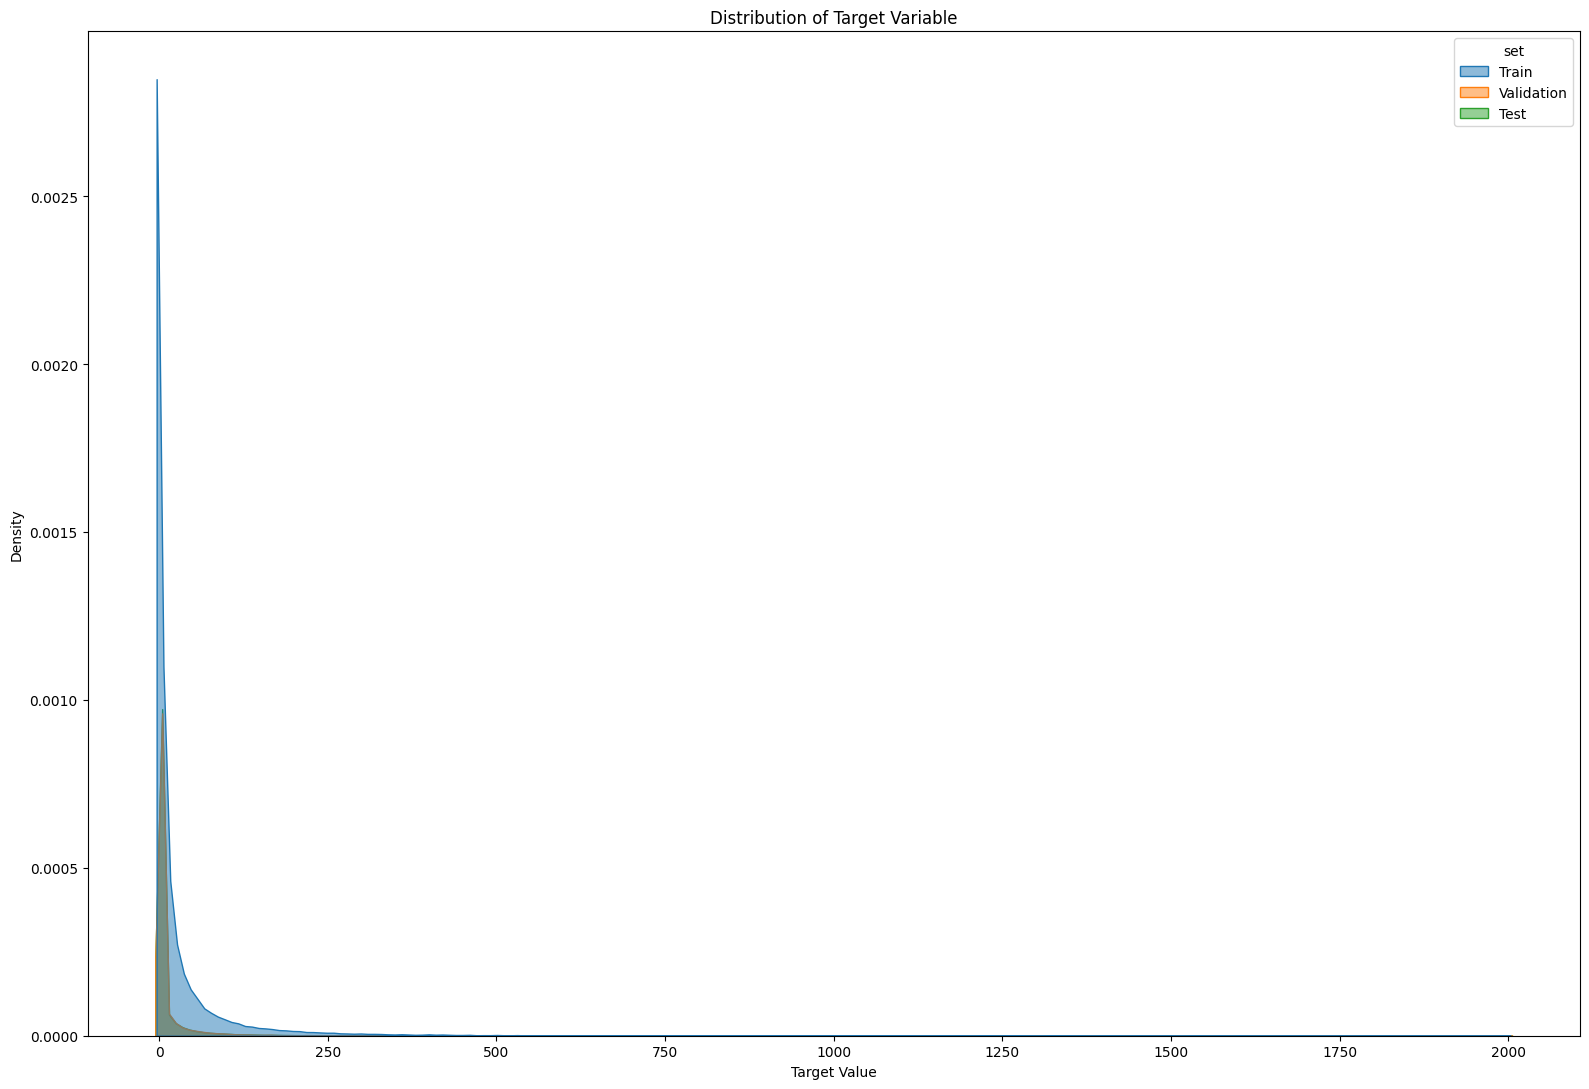

In [15]:
# Combine the datasets into a single DataFrame for plotting
plot_data = pd.concat([
    pd.DataFrame({'value': y_train, 'set': 'Train'}),
    pd.DataFrame({'value': y_val, 'set': 'Validation'}),
    pd.DataFrame({'value': y_test, 'set': 'Test'})
])

# Plot using seaborn
plt.figure(figsize=(16, 11))
sns.kdeplot(data=plot_data, x='value', hue='set', fill=True, alpha=0.5)
plt.title("Distribution of Target Variable")
plt.xlabel("Target Value")
plt.ylabel("Density")
plt.tight_layout()

# 2. Preprocessing

In [16]:
NULL_COLS = [
    "sum_hc_imp_loc_pre_upgradedboosters_last_14d",
]
# 1. Drop columns with 100% missing values
drop_missing_cols_obj = DropFeatures(features_to_drop=NULL_COLS)

# Apply the transformation
x_train = drop_missing_cols_obj.fit_transform(x_train)
x_val = drop_missing_cols_obj.transform(x_val)
x_test = drop_missing_cols_obj.transform(x_test)

In [17]:
# 2. Drop features that are not needed
COLS_TO_DROP = [
    "kingplayerid", 
    "reference_dt",
    "churn_next_30d",
    "is_payer",
]

ADS_COLS_TO_DROP = [
    "ads_segment_at_cutoff",
]

drop_features_obj = DropFeatures(features_to_drop=COLS_TO_DROP+ADS_COLS_TO_DROP)

# Apply the transformation
x_train = drop_features_obj.fit_transform(x_train)
x_val = drop_features_obj.transform(x_val)
x_test = drop_features_obj.transform(x_test)

# NOTE:
# - We have dropped Ads columns because they produce a recall of 1.0 in the model.

In [18]:
# 3a. Impute missing values
fill_with_minus_one_cols = [
    "days_since_convert",       
    "days_since_last_spend",    
    "days_to_convert",
    "highest_level",
]

# Impute missing values with -1 for specified columns (works only with numerical)
arbitrary_imputer_minus_one_obj = ArbitraryNumberImputer(arbitrary_number=-1, variables=fill_with_minus_one_cols)

# Apply the transformation
x_train = arbitrary_imputer_minus_one_obj.fit_transform(x_train)
x_val = arbitrary_imputer_minus_one_obj.transform(x_val)
x_test = arbitrary_imputer_minus_one_obj.transform(x_test)

In [19]:
fill_with_zero_cols = [
    "active_days_last_30d",
    "active_days_last_60d",
    "active_days_last_7d",
    "aps_per_success_30d",
    "aps_per_success_60d",
    "aps_per_success_7d",
    "egp_hc_spend_last_14d",
    "egp_hc_spend_last_7d",
    "egp_hc_trxn_last_14d",
    "egp_hc_trxn_last_7d",
    "gamerounds_last_30d",
    "gamerounds_last_60d",
    "gamerounds_last_7d",
    "num_sessions_last_30d",
    "num_sessions_last_60d",
    "num_sessions_last_7d",
    "play_time_in_ms_last_30d",
    "play_time_in_ms_last_60d",
    "play_time_in_ms_last_7d",
    "purchases_since_install",
    "spend_since_install",
    "sum_hc_imp_last_14d",
    "sum_hc_imp_loc_in_ingamehudbooster_last_14d",
    "sum_hc_imp_loc_levelpin_outoflife_last_14d",
    "sum_hc_imp_loc_map_outoflife_last_14d",
    "sum_hc_imp_loc_map_seasonpass_last_14d",
    "sum_hc_imp_loc_post_dynamicendgame_last_14d",
    "sum_hc_imp_loc_pre_prelevelbooster_last_14d",
    "sum_hc_inflow_last_30d",
    "sum_hc_inflow_last_60d",
    "sum_hc_inflow_last_7d",
    "sum_hc_spent_last_14d",
    "sum_hc_spent_last_30d",
    "sum_hc_spent_last_60d",
    "sum_hc_spent_last_7d",
    "sum_hc_transactions_last_14d",
    "sum_hc_transactions_last_30d",
    "sum_hc_transactions_last_60d",
    "sum_hc_transactions_last_7d",
    "sum_info_popups_last_1_month",
    "sum_purchases_last_30d",
    "sum_purchases_last_60d",
    "sum_purchases_last_7d",
    "sum_rm_imp_last_14d",
    "sum_rm_imp_loc_in_ingamehudbooster_last_14d",
    "sum_rm_imp_loc_levelpin_milestoneoffer_last_14d",
    "sum_rm_imp_loc_map_dynamicoffer_last_14d",
    "sum_rm_imp_loc_map_hardleveloffer_last_14d",
    "sum_rm_imp_loc_map_piggybank_last_14d",
    "sum_rm_imp_loc_map_seasonpass_last_14d",
    "sum_rm_imp_loc_post_dynamicendgame_last_14d",
    "sum_rm_imp_loc_post_dynamicoffer_last_14d",
    "sum_rm_imp_loc_post_seasonpass_last_14d",
    "sum_rm_imp_loc_pre_outoflife_last_14d",
    "sum_rm_spend_usd_last_14d",
    "sum_rm_transactions_last_14d",
    "sum_spend_usd_last_30d",
    "sum_spend_usd_last_60d",
    "sum_spend_usd_last_7d",
]
train_df[fill_with_zero_cols].isnull().sum()

active_days_last_30d                                     0
active_days_last_60d                                     0
active_days_last_7d                                      0
aps_per_success_30d                                 567677
aps_per_success_60d                                 442153
aps_per_success_7d                                 1082893
egp_hc_spend_last_14d                              2670800
egp_hc_spend_last_7d                               3145812
egp_hc_trxn_last_14d                               2670800
egp_hc_trxn_last_7d                                3145812
gamerounds_last_30d                                      0
gamerounds_last_60d                                      0
gamerounds_last_7d                                       0
num_sessions_last_30d                                    0
num_sessions_last_60d                                    0
num_sessions_last_7d                                     0
play_time_in_ms_last_30d                              13

In [20]:
# 3b. Impute missing values
fill_with_zero_cols = [
    "active_days_last_30d",
    "active_days_last_60d",
    "active_days_last_7d",
    "aps_per_success_30d",
    "aps_per_success_60d",
    "aps_per_success_7d",
    "egp_hc_spend_last_14d",
    "egp_hc_spend_last_7d",
    "egp_hc_trxn_last_14d",
    "egp_hc_trxn_last_7d",
    "gamerounds_last_30d",
    "gamerounds_last_60d",
    "gamerounds_last_7d",
    "num_sessions_last_30d",
    "num_sessions_last_60d",
    "num_sessions_last_7d",
    "play_time_in_ms_last_30d",
    "play_time_in_ms_last_60d",
    "play_time_in_ms_last_7d",
    "purchases_since_install",
    "spend_since_install",
    "sum_hc_imp_last_14d",
    "sum_hc_imp_loc_in_ingamehudbooster_last_14d",
    "sum_hc_imp_loc_levelpin_outoflife_last_14d",
    "sum_hc_imp_loc_map_outoflife_last_14d",
    "sum_hc_imp_loc_map_seasonpass_last_14d",
    "sum_hc_imp_loc_post_dynamicendgame_last_14d",
    "sum_hc_imp_loc_pre_prelevelbooster_last_14d",
    "sum_hc_inflow_last_30d",
    "sum_hc_inflow_last_60d",
    "sum_hc_inflow_last_7d",
    "sum_hc_spent_last_14d",
    "sum_hc_spent_last_30d",
    "sum_hc_spent_last_60d",
    "sum_hc_spent_last_7d",
    "sum_hc_transactions_last_14d",
    "sum_hc_transactions_last_30d",
    "sum_hc_transactions_last_60d",
    "sum_hc_transactions_last_7d",
    "sum_info_popups_last_1_month",
    "sum_purchases_last_30d",
    "sum_purchases_last_60d",
    "sum_purchases_last_7d",
    "sum_rm_imp_last_14d",
    "sum_rm_imp_loc_in_ingamehudbooster_last_14d",
    "sum_rm_imp_loc_levelpin_milestoneoffer_last_14d",
    "sum_rm_imp_loc_map_dynamicoffer_last_14d",
    "sum_rm_imp_loc_map_hardleveloffer_last_14d",
    "sum_rm_imp_loc_map_piggybank_last_14d",
    "sum_rm_imp_loc_map_seasonpass_last_14d",
    "sum_rm_imp_loc_post_dynamicendgame_last_14d",
    "sum_rm_imp_loc_post_dynamicoffer_last_14d",
    "sum_rm_imp_loc_post_seasonpass_last_14d",
    "sum_rm_imp_loc_pre_outoflife_last_14d",
    "sum_rm_spend_usd_last_14d",
    "sum_rm_transactions_last_14d",
    "sum_spend_usd_last_30d",
    "sum_spend_usd_last_60d",
    "sum_spend_usd_last_7d",
]

# Impute missing values with 0 for specified columns
arbitrary_imputer_zero_obj = ArbitraryNumberImputer(arbitrary_number=0, variables=fill_with_zero_cols)

# Apply the transformation
x_train = arbitrary_imputer_zero_obj.fit_transform(x_train)
x_val = arbitrary_imputer_zero_obj.transform(x_val)
x_test = arbitrary_imputer_zero_obj.transform(x_test)

In [21]:
# 5. Categorical imputation with "missing"
CATEGORICAL_COLS = [
    "spend_segment_at_cutoff",
    "engagement_segment_at_cutoff",
    "progression_segment_at_cutoff",
    "countrytier_segment_at_cutoff",
    "platformid_segment_at_cutoff",
    "friendship_segment_at_cutoff",
    # "ads_segment_at_cutoff",   # Dropped in 1st step because of ads column
    "tenure_segment_at_cutoff",
    "loyalty_segment_at_cutoff",
    "countrygroup_segment_at_cutoff",
]
categorical_imputer_obj = CategoricalImputer(
    imputation_method="missing", fill_value="missing", variables=CATEGORICAL_COLS
    )

# Apply the transformation
x_train = categorical_imputer_obj.fit_transform(x_train)
x_val = categorical_imputer_obj.transform(x_val)
x_test = categorical_imputer_obj.transform(x_test)

In [22]:
# 6a. Nominal encoding for categorical features
NOMINAL_COLS = [
    "first_seen_country_codes", 
    "last_seen_country_codes",
    "first_os",
    "last_os",
]
nominal_encoder_obj = OrdinalEncoder(
    encoding_method="arbitrary",  # Assign arbitrary integers to categories
    variables=NOMINAL_COLS,
    unseen="encode",
)

# Apply the transformation
x_train = nominal_encoder_obj.fit_transform(x_train)
x_val = nominal_encoder_obj.transform(x_val)
x_test = nominal_encoder_obj.transform(x_test)

In [23]:
# 6b. Ordinal encoding for categorical features
ORDINAL_COLS = [
    "spend_segment_at_cutoff",
    "engagement_segment_at_cutoff",
    "progression_segment_at_cutoff",
    "countrytier_segment_at_cutoff",
    "platformid_segment_at_cutoff",
    "friendship_segment_at_cutoff",
    # "ads_segment_at_cutoff", # Dropped as an ads column
    "tenure_segment_at_cutoff",
    "loyalty_segment_at_cutoff",
    "countrygroup_segment_at_cutoff",
]
ordinal_encoder_obj = OrdinalEncoder(
    encoding_method="ordered",
    variables=ORDINAL_COLS,
    unseen="encode",
)

# Apply the transformation
x_train = ordinal_encoder_obj.fit_transform(x_train, y_train)
x_val = ordinal_encoder_obj.transform(x_val)
x_test = ordinal_encoder_obj.transform(x_test)

/Users/ioannis.mesionis/Library/Caches/pypoetry/virtualenvs/candy-iap-glint-vip-CL6_0Y6a-py3.11/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


In [24]:
# # Do a dtype correction due to a discrepancy produced by the nominal encoder
# x_val["first_seen_country_codes"] = x_val["first_seen_country_codes"].astype(int)
# x_val["last_seen_country_codes"] = x_val["last_seen_country_codes"].astype(int)
# x_val["first_os"] = x_val["first_os"].astype(int)

# x_test["first_seen_country_codes"] = x_test["first_seen_country_codes"].astype(int)
# x_test["last_seen_country_codes"] = x_test["last_seen_country_codes"].astype(int)
# x_test["first_os"] = x_test["first_os"].astype(int)

In [25]:
# Ensure no missing values
x_train.isnull().sum().sum(), x_val.isnull().sum().sum(), x_test.isnull().sum().sum()

(0, 0, 0)

In [26]:
# Visual inspection
print("Train data types")
print(x_train.head().dtypes.value_counts())
print("\n")

print("Validation data types")
print(x_val.head().dtypes.value_counts())
print("\n")

print("Test data types")
print(x_test.head().dtypes.value_counts())

Train data types
float64    66
int64      13
Name: count, dtype: int64


Validation data types
float64    68
int64      11
Name: count, dtype: int64


Test data types
float64    69
int64      10
Name: count, dtype: int64


# 3. Feature Selection

In [ ]:
# Selecting the model parameters
params = {
    "objective": "tweedie",
    "importance_type": "gain",
    "random_state": SEED,
    "n_jobs": -1,
    "tweedie_variance_power": 1.5,
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "force_row_wise": "true",
    "early_stopping_round": 10,
    "verbosity": 2,
}

# Defining the categorical features
CATEGORICAL_FEATURES = NOMINAL_COLS + ORDINAL_COLS

In [ ]:
# Train a LightGBM regressor for feature selection
lgb_model = lgb.LGBMRegressor(**params)
lgb_model = lgb_model.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=["r2", "rmse"],
    categorical_feature=CATEGORICAL_FEATURES,
)

In [ ]:
# Predict on validation (or test) set
y_pred = lgb_model.predict(x_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R²: {r2:.4f}")

In [ ]:
# Plot the feature importance
MAX_NUM_FEATURES = 10 # Top 10 features

lgb.plot_importance(
    lgb_model, importance_type="gain", max_num_features=MAX_NUM_FEATURES, figsize=(16, 11)
    )
plt.tight_layout()

In [ ]:
# Store the feature importances
importances = lgb_model.booster_.feature_importance(importance_type="gain")
feature_names = x_train.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.head(10)

In [ ]:
# Plot the shap explanation
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer(x_test)

# Summarize feature importance
shap.summary_plot(shap_values, x_test)

In [ ]:
# Get the feature importances based on the shap values
shap_values_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), columns=["mean_abs_shap"])
shap_values_df["feature"] = x_val.columns
shap_values_df = shap_values_df.sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

# Cumulative SHAP contribution
shap_values_df["cumulative_importance"] = shap_values_df["mean_abs_shap"].cumsum() / shap_values_df["mean_abs_shap"].sum()
shap_values_df = shap_values_df[["feature", "mean_abs_shap", "cumulative_importance"]] # Just reordering the columns
shap_values_df.sort_values(by="cumulative_importance", ascending=True).head(10)

# NOTE:
# - Since we are optimising on explainability SHAP values are preferable compared to feature importance.

In [ ]:
# Select features contributing to 99% of SHAP impact
CI_THRESHOLD = 0.99

selected_features = shap_values_df[shap_values_df["cumulative_importance"] <= CI_THRESHOLD]["feature"].tolist()
len(selected_features)

# NOTE:
# - CI_THRESHOLD = 0.99 is a good rule of thumb selection for POCs with interpretability.

In [27]:
# Use this cell if not want to run the feature selection
selected_features = [
    # Categorical Features
    "first_seen_country_codes",
    "last_seen_country_codes",
    "first_os",
    "last_os",
    "spend_segment_at_cutoff",
    "countrytier_segment_at_cutoff",
    "tenure_segment_at_cutoff",
    "countrygroup_segment_at_cutoff",
    
    # Numerical Features
    "spend_since_install",
    "sum_spend_usd_last_60d",
    "active_days_last_60d",
    "sum_hc_transactions_last_14d",   # Feature to vary
    "sum_rm_imp_loc_map_piggybank_last_14d",
    "sum_rm_imp_loc_map_dynamicoffer_last_14d",
    "days_since_last_spend",
    "sum_hc_spent_last_60d",
    "gamerounds_last_7d",
    "sum_hc_spent_last_7d",
    "sum_hc_inflow_last_7d",
    "sum_hc_spent_last_30d",
    "highest_level",
    "sum_hc_imp_loc_in_ingamehudbooster_last_14d",
    "days_since_install",
    "days_since_last_activity",
    "num_sessions_last_7d",
    "sum_rm_imp_loc_post_dynamicendgame_last_14d",
    "days_to_convert",
    "egp_hc_trxn_last_7d",            
    "egp_hc_spend_last_7d",           # Feature to vary
    "purchases_since_install",
    "sum_info_popups_last_1_month",
    "play_time_in_ms_last_60d",
    "aps_per_success_7d",             # Feature to vary
    "aps_per_success_60d",
    "sum_spend_usd_last_30d",
    "days_since_convert",
    "gamerounds_last_60d",
    "sum_hc_imp_loc_pre_prelevelbooster_last_14d",
    "num_sessions_last_30d",
    "sum_hc_imp_loc_map_outoflife_last_14d",
    "sum_hc_imp_loc_map_seasonpass_last_14d",
    "sum_hc_spent_last_14d",
    "gamerounds_last_30d",
    "sum_rm_spend_usd_last_14d",
    "sum_hc_imp_last_14d",
    "sum_hc_inflow_last_30d",
    "sum_hc_inflow_last_60d",
    "sum_rm_imp_last_14d",
]

In [28]:
# Filter on selected features
x_train_selected = x_train[selected_features].copy()
x_val_selected = x_val[selected_features].copy()
x_test_selected = x_test[selected_features].copy()

In [29]:
# Test the shapes
x_train_selected.shape, x_val_selected.shape, x_test_selected.shape

((5442428, 48), (681027, 48), (679731, 48))

# 4. ML Model

In [30]:
params = {
    "objective": "tweedie",
    "importance_type": "gain",
    "random_state": SEED,
    "n_jobs": -1,
    "tweedie_variance_power": 1.5,
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "force_row_wise": "true",
    "early_stopping_round": 10,
    "verbosity": 2,
}

CATEGORICAL_SELECTED_FEATURES = [
    "first_seen_country_codes",
    "last_seen_country_codes",
    "first_os",
    "last_os",
    "spend_segment_at_cutoff",
    "countrytier_segment_at_cutoff",
    "tenure_segment_at_cutoff",
    "countrygroup_segment_at_cutoff",
]

In [31]:
# Train a LightGBM regressor with the selected features
selected_lgb_model = lgb.LGBMRegressor(**params)
selected_lgb_model = selected_lgb_model.fit(
    x_train_selected,
    y_train,
    eval_set=[(x_val_selected, y_val)],
    eval_metric=["r2", "rmse"],
    categorical_feature=CATEGORICAL_SELECTED_FEATURES,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.448789
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 5442428, number of used features: 48
[LightGBM] [Info] Start training from score 0.794437
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
Training until validation scores don't improve for 10 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a t

In [32]:
# Predict on validation (or test) set
y_pred = selected_lgb_model.predict(x_test_selected)

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R²: {r2:.4f}")

✅ RMSE: 15.6887
✅ MAE: 1.3974
✅ R²: 0.6530


/Users/ioannis.mesionis/Library/Caches/pypoetry/virtualenvs/candy-iap-glint-vip-CL6_0Y6a-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


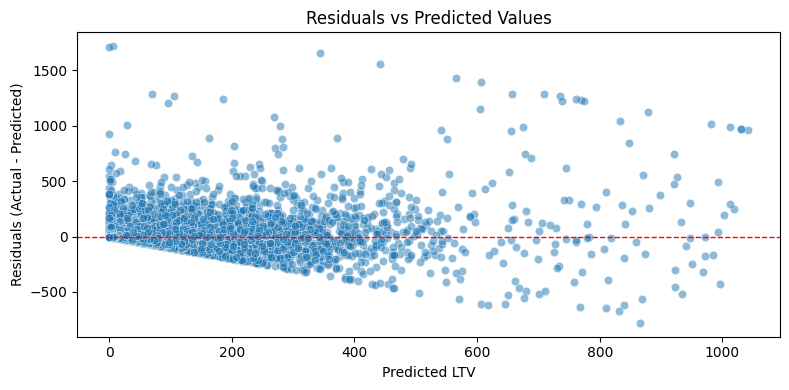

In [33]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted LTV")
plt.ylabel("Residuals (Actual - Predicted)")
plt.tight_layout()
plt.show()

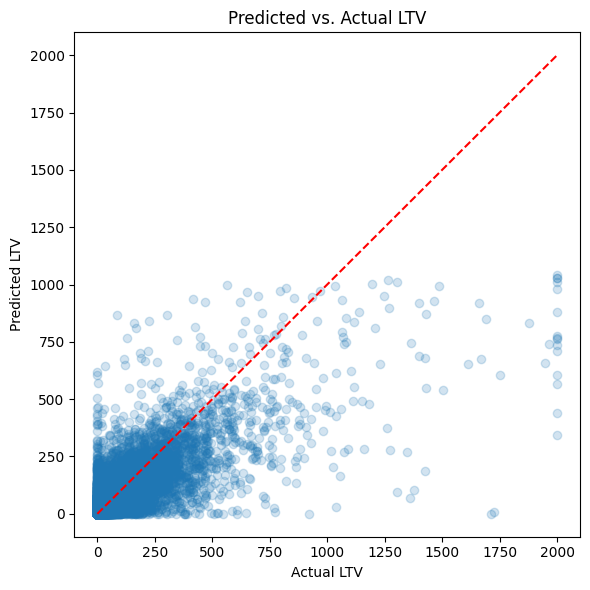

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Predicted vs. Actual LTV")
plt.tight_layout()
plt.show()

# 5. Counterfactual Explanations

## 5.1. DiCE Model

In [35]:
# Combine train data with target as it is expected from DiCE
dice_x_test_selected = pd.concat([x_test_selected, y_test], axis=1)

In [36]:
# 1. Define the DiCE ML data object
dice_x_test_obj = dice_ml.Data(
    dataframe=dice_x_test_selected,
    continuous_features=dice_x_test_selected.drop([TARGET], axis=1).columns.tolist(), # Target column should be excluded
    outcome_name=TARGET,
    )
dice_x_test_obj

In [37]:
# 2. Define the DiCE model object
dice_xgb_model_obj = dice_ml.Model(model=selected_lgb_model, backend="sklearn", model_type="regressor")
dice_xgb_model_obj

In [38]:
# 3. Define the counterfactual explanation object
ce_object = dice_ml.Dice(dice_x_test_obj, dice_xgb_model_obj, method="random")
ce_object

# NOTE:
# - For tree-based models (like LightGBM), "random" and "genetic" are preferrable:
#   1] "random" is fast and simple, but may produce less diverse or optimal counterfactuals.
#      This approach involves randomly changing feature values of the instance of interest and stopping when the desired output is predicted.

#   2] "genetic" is slower, but tends to find better (lower-cost) counterfactuals.

The **random method** implementation as suggested by Wachter et. al (2017) is generating counterfactual by minimising the following loss function:
$$
L(x, x', y', \lambda) = \lambda \cdot \left( \hat{f}(x') - y' \right)^2 + d(x, x')
$$

where:
- first term: quadratic distance between the model prediction for the counterfactual $x’$ and the desired outcome $y’$, that must be defined in advance.
- second term: The second term is the distance $d$ between the instance $x$ to be explained and the counterfactual $x’$.
- $\lambda$ parameter balances the distance in prediction against the distance in feature values.
  - higher value of $\lambda$ means that we prefer counterfactuals that come close to the desired outcome $y’$.
  - lower value means that we prefer counterfactuals $x’$ that are very similar to $x$ in the feature values
- The L1(Manhattan) Distance is used **d**: $d(x, x') = \sum_{j=1}^p \frac{|x_j - x'_j|}{MAD_j}$


The loss is solved for a given $\lambda$ and returns a counterfactual $x’$. <br>
Finally, for how far away the prediction of the counterfactual instance is allowed to be from y’. This constraint can be written as $\left| \hat{f}(x') - y' \right| \leq \epsilon$.

[Source](https://arxiv.org/pdf/1905.07697)

In [39]:
INDEX = 25 # An old index from train is the 20th index

query_instance = dice_x_test_selected[dice_x_test_selected[TARGET] > 0].drop(TARGET, axis=1).iloc[[INDEX]]  # Use double brackets to keep it as a DataFrame (more than one row can be passed)
query_instance

# NOTE:
# - Does not require the target variable.

,first_seen_country_codes,last_seen_country_codes,first_os,last_os,spend_segment_at_cutoff,countrytier_segment_at_cutoff,tenure_segment_at_cutoff,countrygroup_segment_at_cutoff,spend_since_install,sum_spend_usd_last_60d,...,num_sessions_last_30d,sum_hc_imp_loc_map_outoflife_last_14d,sum_hc_imp_loc_map_seasonpass_last_14d,sum_hc_spent_last_14d,gamerounds_last_30d,sum_rm_spend_usd_last_14d,sum_hc_imp_last_14d,sum_hc_inflow_last_30d,sum_hc_inflow_last_60d,sum_rm_imp_last_14d
814,32.0,32.0,1.0,1,1,0,0,0,1893.848084,63.942009,...,35.0,0.0,0.0,20.0,281.0,4.960478,28.0,249.0,549.0,21.0


In [40]:
# Get the model prediction value
print("Prediction Outcome:", selected_lgb_model.predict(query_instance))

# NOTE:
# - The ML prediction is used to understand how to select the desired_range in the next cell.
# - One of the ideas is that a group of people could be selected (e.g. payers) and define a percentage to increase their LTV to automate the procedure.

Prediction Outcome: [30.48647656]


In [41]:
FEATURES_TO_VARY = ["egp_hc_spend_last_7d", "aps_per_success_7d", "sum_hc_spent_last_7d"]

# Generate counterfactuals
cf_examples = ce_object.generate_counterfactuals(
    query_instance,
    total_CFs=3,  # Number of counterfactuals to generate
    desired_range=(32, 35),  # Define the new LTV range we want as counterfactual
    features_to_vary=FEATURES_TO_VARY     # List of specific actionable features e.g. ["egp_hc_spend_last_7d", "aps_per_success_7d", "sum_hc_spent_last_7d"]
)

# NOTE:
# - There can also be a permitted range (e.g. permitted_range={'aps_per_success_7d': [0, ], 'hours_per_week': [40, 60]}))

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


In [42]:
cf_examples.visualize_as_dataframe(show_only_changes=True)

# NOTE:
# - Original outcome corresponds to the prediction (rounded)

Query instance (original outcome : 30.0)


,first_seen_country_codes,last_seen_country_codes,first_os,last_os,spend_segment_at_cutoff,countrytier_segment_at_cutoff,tenure_segment_at_cutoff,countrygroup_segment_at_cutoff,spend_since_install,sum_spend_usd_last_60d,...,sum_hc_imp_loc_map_outoflife_last_14d,sum_hc_imp_loc_map_seasonpass_last_14d,sum_hc_spent_last_14d,gamerounds_last_30d,sum_rm_spend_usd_last_14d,sum_hc_imp_last_14d,sum_hc_inflow_last_30d,sum_hc_inflow_last_60d,sum_rm_imp_last_14d,sum_spend_usd_next_30d
0,32.0,32.0,1.0,1,1,0,0,0,1893.848145,63.942009,...,0.0,0.0,20.0,281.0,4.960478,28.0,249.0,549.0,21.0,30.0



Diverse Counterfactual set (new outcome: (32, 35))


,first_seen_country_codes,last_seen_country_codes,first_os,last_os,spend_segment_at_cutoff,countrytier_segment_at_cutoff,tenure_segment_at_cutoff,countrygroup_segment_at_cutoff,spend_since_install,sum_spend_usd_last_60d,...,sum_hc_imp_loc_map_outoflife_last_14d,sum_hc_imp_loc_map_seasonpass_last_14d,sum_hc_spent_last_14d,gamerounds_last_30d,sum_rm_spend_usd_last_14d,sum_hc_imp_last_14d,sum_hc_inflow_last_30d,sum_hc_inflow_last_60d,sum_rm_imp_last_14d,sum_spend_usd_next_30d
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,33.92045974731445
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,33.871070861816406
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,34.59651184082031


In [43]:
# Can also visualise as a list for better visibility 
cf_examples.visualize_as_list(show_only_changes=True)

Query instance (original outcome : 30.0)
[32.0, 32.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1893.84814453125, 63.94200897216797, 26.0, 2.0, 2.0, 8.0, 2.0, 592.0, 13.0, 10.0, 40.0, 251.0, 5733.0, 1.0, 1148.0, 2.0, 2.0, 1.0, 3.0, 1.0, 10.0, 598.0, 1122.0, 77503000.0, 0.1538461595773697, 0.32763975858688354, 35.37930679321289, 1145.0, 644.0, 0.0, 35.0, 0.0, 0.0, 20.0, 281.0, 4.960477828979492, 28.0, 249.0, 549.0, 21.0, 30.0]

Diverse Counterfactual set (new outcome: (32, 35))
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 102.9, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 6991.4, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 33.92045974731445]
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 105.0, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 5.2, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 33.871070861816406]
['

In [44]:
# The example that was passed
cf_examples.cf_examples_list[0].test_instance_df.iloc[[0]][["sum_hc_spent_last_7d", "aps_per_success_7d", "egp_hc_spend_last_7d", TARGET]]

,sum_hc_spent_last_7d,aps_per_success_7d,egp_hc_spend_last_7d,sum_spend_usd_next_30d
0,10.0,0.153846,10.0,30.0


In [45]:
# Explore the counterfactuals
cf_examples.cf_examples_list[0].final_cfs_df[["sum_hc_spent_last_7d", "aps_per_success_7d", "egp_hc_spend_last_7d", TARGET]]

,sum_hc_spent_last_7d,aps_per_success_7d,egp_hc_spend_last_7d,sum_spend_usd_next_30d
0,102.9,0.153846,6991.4,34.0
1,105.0,5.200000,10.0,34.0
2,192.2,5.300000,10.0,35.0


## 5.2. Alibi

> Similarly to COLA, the alibi library **does not allow the generation of counterfactuals for regression**. However, it provides some understanding (e.g. local and global) of the model predictions.

In [ ]:
import alibi
alibi.explainers.__all__

In [ ]:
# The majority of the different explainers can be used in the following format:

# predictor = model.predict
# explainer = SomeExplainer(predictor, **kwargs)

In [ ]:
# Example implementation of the TreeSHAP explainer
explainer = alibi.explainers.TreeShap(
    selected_lgb_model,
    feature_names=x_train_selected.columns.tolist(),
    # categorical_names={0: ['S', 'M', 'L', 'XL', 'XXL']}
)
explainer.fit(model_output="raw", task="regression")

# NOTE:
# The following implementation generates an error, not sure why yet.
# Source -> https://docs.seldon.io/projects/alibi/en/stable/explanations/examples.html#tree-shap

## 5.3. COLA framework

> Cola framework **cannot** be implemented as it is only available for Classification.

The code that has been implemented below just demonstrates the usage of COLA if the regression implementation was available.

In [ ]:
# Add COLA to path
str(Path.cwd().parents[1])
sys.path.append(str(Path.cwd().parents[1]))

from COLA.xai_cola import data_interface, ml_model_interface
from COLA.counterfactual_explainer import DiCE, AlibiCounterfactualInstances
from COLA.xai_cola.counterfactual_limited_actions import COLA

# NOTE:
# - The entire Github repo has been cloned and its code has been changed to be imported.

In [ ]:
# 1. Initialise the COLA data interface
cola_df_obj = data_interface.PandasData(dice_x_test_selected.drop(TARGET, axis=1), target_name=TARGET)
cola_df_obj

In [ ]:
# 2. Define the cola model object
cola_lgb_model = ml_model_interface.Model(model=selected_lgb_model, backend="sklearn")
cola_lgb_model

In [ ]:
# Define the features to keep
FEATURES_TO_KEEP = set(dice_x_test_selected.drop(TARGET, axis=1).columns.tolist()).difference(FEATURES_TO_VARY)

In [ ]:
# Choose the explainer to be used
explainer = DiCE(ml_model=cola_lgb_model)
explainer = AlibiCounterfactualInstances(ml_model=cola_lgb_model)

# Generate counterfactual explanations
factual, counterfactual = explainer.generate_counterfactuals(
    data=cola_df_obj,
    factual_class=1,
    total_cfs=3,
    features_to_keep=FEATURES_TO_KEEP,
    )

# BUG:
# - The cola explainer is a wrapper around DiCE, so the same parameters are used. However, it is just for Classification.